In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 10000.xlsx to 10000.xlsx


In [ ]:
!pip install rdkit scikit-learn xgboost tensorflow joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 53.4 MB/s eta 0:00:00


Attempting to load dataset from: /content/10000.csv
Initial dataset loaded. Rows: 10049, Columns: ['comp', 'Tg', 'Tm', 'Td', 'YM', 'TS_y', 'TS_b', 'eps_b', 'perm_O2', 'perm_CO2', 'perm_He', 'perm_N2', 'perm_CH4', 'perm_H2', 'smiles', 'num_side', 'num_back', 'end_group']
Numeric columns: Index(['comp', 'Tg', 'Tm', 'Td', 'YM', 'TS_y', 'TS_b', 'eps_b', 'perm_O2',
       'perm_CO2', 'perm_He', 'perm_N2', 'perm_CH4', 'perm_H2'],
      dtype='object')
Missing values before filling:
comp        0
Tg          0
Tm          0
Td          0
YM          0
TS_y        0
TS_b        0
eps_b       0
perm_O2     0
perm_CO2    0
perm_He     0
perm_N2     0
perm_CH4    0
perm_H2     0
dtype: int64
Missing values after filling:
comp        0
Tg          0
Tm          0
Td          0
YM          0
TS_y        0
TS_b        0
eps_b       0
perm_O2     0
perm_CO2    0
perm_He     0
perm_N2     0
perm_CH4    0
perm_H2     0
dtype: int64
Removed 0 duplicate rows. Remaining rows: 10049
SMILES validation: 1004

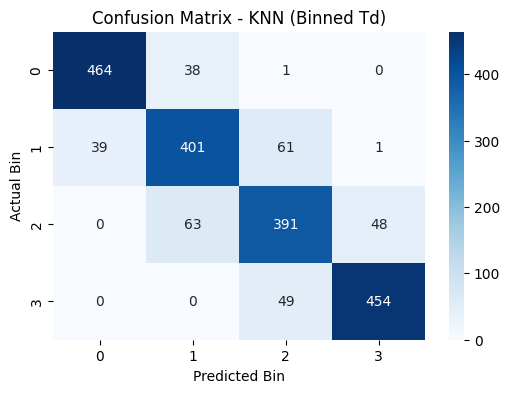

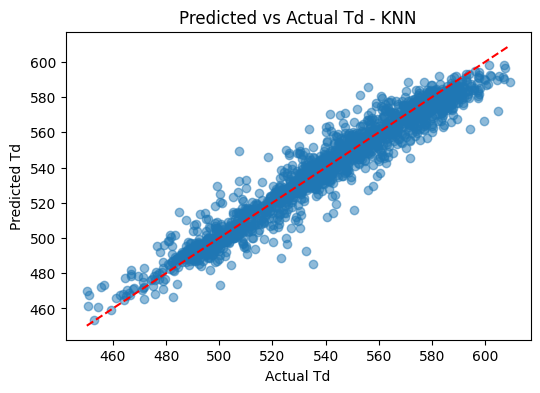

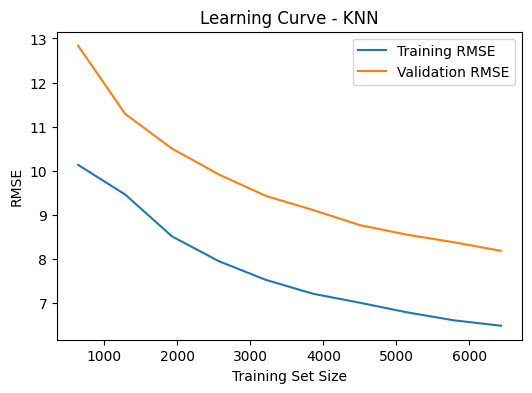

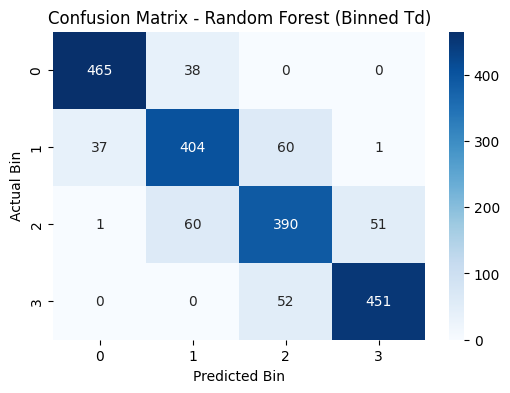

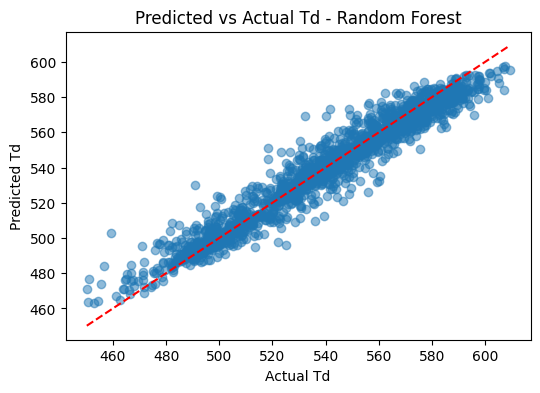

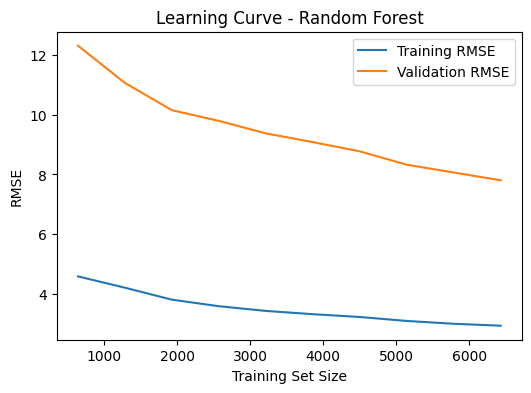

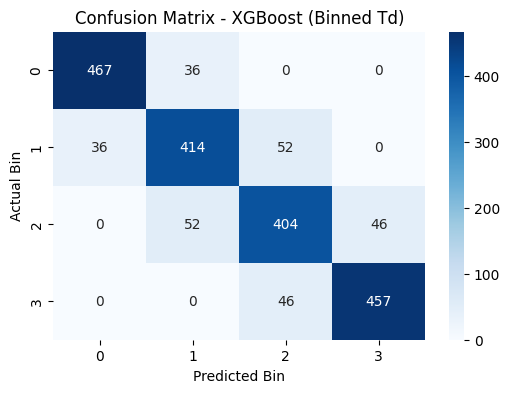

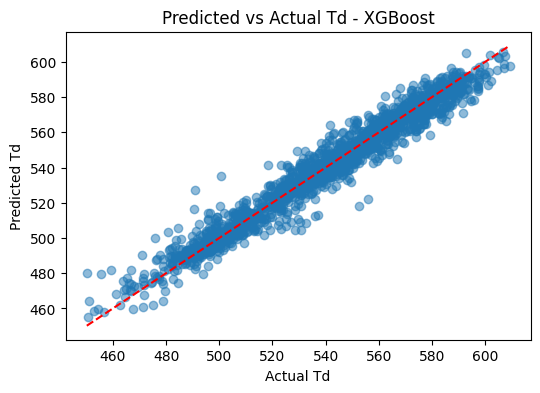

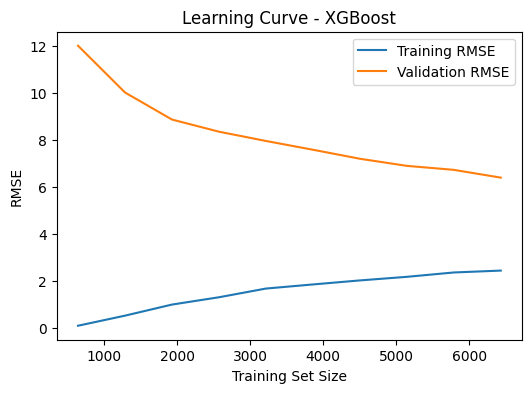


Model Comparison Table:


,Model,RMSE,R2,Best Model
KNN,KNN,7.741360,0.940481,False
Random Forest,Random Forest,7.428605,0.945193,False
XGBoost,XGBoost,6.318833,0.960346,True



Best Model: XGBoost

Enter a SMILES string (e.g., [*]OCCC(=O)[*]) or a pair (e.g., ['[*]OCCC(=O)[*]', '[*]OC(O)CC(=O)[*]']) or 'quit' to exit:
 [*]OCCC(=O)[*]
Predicted Td: 501.08

Enter a SMILES string (e.g., [*]OCCC(=O)[*]) or a pair (e.g., ['[*]OCCC(=O)[*]', '[*]OC(O)CC(=O)[*]']) or 'quit' to exit:
quit
Exiting prediction.


In [ ]:
!pip install rdkit scikit-learn xgboost tensorflow joblib
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import joblib
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Step 1: Load and Clean the Dataset
def load_and_clean_data(file_path):
    print(f"Attempting to load dataset from: {file_path}")
    try:
        df = pd.read_csv(file_path)
        print(f"Initial dataset loaded. Rows: {len(df)}, Columns: {list(df.columns)}")
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return pd.DataFrame()

    if df.empty:
        print("Error: Loaded dataset is empty.")
        return df

    # Check for required columns
    required_cols = ['smiles', 'Td']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Warning: Missing required columns: {missing_cols}")
        if 'smiles' not in df.columns:
            print("Adding default SMILES column.")
            df['smiles'] = '[*]OCCC(=O)[*]'
        if 'Td' not in df.columns:
            print("Error: 'Td' column is required.")
            return pd.DataFrame()

    # Handle missing values
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    print(f"Numeric columns: {numeric_cols}")
    print(f"Missing values before filling:\n{df[numeric_cols].isnull().sum()}")
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    print(f"Missing values after filling:\n{df[numeric_cols].isnull().sum()}")

    # Remove duplicates
    initial_rows = len(df)
    df = df.drop_duplicates()
    print(f"Removed {initial_rows - len(df)} duplicate rows. Remaining rows: {len(df)}")

    # Validate SMILES strings
    def is_valid_smiles(smiles_input):
        try:
            try:
                smiles_list = ast.literal_eval(smiles_input)
                if not isinstance(smiles_list, list) or len(smiles_list) == 0 or len(smiles_list) > 2:
                    return False
                for smi in smiles_list:
                    if not isinstance(smi, str):
                        return False
                    mol = Chem.MolFromSmiles(smi, sanitize=True)
                    if mol is None:
                        return False
                return True
            except (ValueError, SyntaxError):
                if not isinstance(smiles_input, str):
                    return False
                mol = Chem.MolFromSmiles(smiles_input, sanitize=True)
                return mol is not None
        except Exception:
            return False

    if 'smiles' in df.columns:
        df['valid_smiles'] = df['smiles'].apply(is_valid_smiles)
        valid_rows = df['valid_smiles'].sum()
        print(f"SMILES validation: {valid_rows} valid, {len(df) - valid_rows} invalid")
        if valid_rows == 0:
            print("Warning: No valid SMILES found. Using default descriptors.")
            invalid_smiles = df[~df['valid_smiles']]['smiles'].head(5).tolist()
            print(f"Sample of invalid SMILES: {invalid_smiles}")
        else:
            df = df[df['valid_smiles']]
            print(f"After SMILES validation, remaining rows: {len(df)}")
        df = df.drop(columns=['valid_smiles'], errors='ignore')

    print(f"Final cleaned dataset. Rows: {len(df)}, Columns: {list(df.columns)}")
    return df

# Step 2: Convert SMILES to Numerical Features
def smiles_to_descriptors(smiles_input):
    default_descriptors = [0.0] * 10
    try:
        descriptors = []
        try:
            smiles_list = ast.literal_eval(smiles_input)
            if not isinstance(smiles_list, list) or len(smiles_list) == 0 or len(smiles_list) > 2:
                return default_descriptors
        except (ValueError, SyntaxError):
            smiles_list = [smiles_input]

        for smi in smiles_list:
            if not isinstance(smi, str):
                return default_descriptors
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                return default_descriptors
            desc = [
                Descriptors.MolWt(mol),
                Descriptors.NumValenceElectrons(mol),
                Descriptors.TPSA(mol),
                Descriptors.NumRotatableBonds(mol),
                Descriptors.MolLogP(mol)
            ]
            descriptors.extend(desc)

        if len(smiles_list) == 1:
            descriptors.extend([0.0] * 5)

        return descriptors
    except Exception:
        return default_descriptors

def prepare_features_and_target(df):
    if df.empty:
        print("Error: Input dataset is empty.")
        return pd.DataFrame(), pd.Series(), []

    if 'Td' not in df.columns:
        print("Error: 'Td' column missing from dataset.")
        return pd.DataFrame(), pd.Series(), []

    descriptor_cols = [
        'mol_wt_1', 'valence_electrons_1', 'tpsa_1', 'rot_bonds_1', 'logp_1',
        'mol_wt_2', 'valence_electrons_2', 'tpsa_2', 'rot_bonds_2', 'logp_2'
    ]

    if 'smiles' in df.columns:
        descriptors = df['smiles'].apply(smiles_to_descriptors)
        descriptor_df = pd.DataFrame(descriptors.tolist(), index=df.index, columns=descriptor_cols)
        df = pd.concat([df, descriptor_df], axis=1)
        print(f"Extracted descriptors for {len(df)} rows.")
    else:
        print("No 'smiles' column. Initializing descriptor columns with zeros.")
        df[descriptor_cols] = 0.0

    feature_cols = descriptor_cols + [col for col in df.columns if col in ['comp', 'Tg', 'Tm', 'YM', 'TS_y', 'TS_b', 'eps_b', 'perm_O2', 'perm_CO2', 'perm_He', 'perm_N2', 'perm_CH4', 'perm_H2']]
    print(f"Selected features: {feature_cols}")

    X = df[feature_cols]
    y = df['Td']

    print(f"Feature matrix shape: {X.shape}, Target shape: {y.shape}")
    return X, y, feature_cols

# Step 3: Train and Evaluate Models with Plots
def train_and_evaluate_models(X, y):
    if X.empty or y.empty:
        print("Error: Empty feature or target data.")
        return {}, {}, None

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training set: {X_train.shape[0]} rows, Test set: {X_test.shape[0]} rows")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        'KNN': KNeighborsRegressor(n_neighbors=5),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    }

    results = {}
    predictions = {}

    # Bin Td for confusion matrix
    bins = pd.qcut(y_test, q=4, labels=False, duplicates='drop')
    num_bins = len(np.unique(bins))
    print(f"Using {num_bins} bins for confusion matrix.")

    # Train and evaluate models
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results[name] = {'RMSE': rmse, 'R2': r2}
        predictions[name] = y_pred

        # Binned confusion matrix
        y_pred_binned = pd.qcut(y_pred, q=4, labels=False, duplicates='drop')
        cm = confusion_matrix(bins, y_pred_binned)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name} (Binned Td)')
        plt.xlabel('Predicted Bin')
        plt.ylabel('Actual Bin')
        plt.savefig(f'confusion_matrix_{name.lower().replace(" ", "_")}.png')
        plt.show()

        # Scatter plot: Predicted vs Actual
        plt.figure(figsize=(6, 4))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Actual Td')
        plt.ylabel('Predicted Td')
        plt.title(f'Predicted vs Actual Td - {name}')
        plt.savefig(f'scatter_{name.lower().replace(" ", "_")}.png')
        plt.show()

        # Learning curve
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error',
            train_sizes=np.linspace(0.1, 1.0, 10)
        )
        train_rmse = -train_scores.mean(axis=1)
        val_rmse = -val_scores.mean(axis=1)
        plt.figure(figsize=(6, 4))
        plt.plot(train_sizes, train_rmse, label='Training RMSE')
        plt.plot(train_sizes, val_rmse, label='Validation RMSE')
        plt.xlabel('Training Set Size')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curve - {name}')
        plt.legend()
        plt.savefig(f'learning_curve_{name.lower().replace(" ", "_")}.png')
        plt.show()

    # Comparison table
    comparison_df = pd.DataFrame(results).T
    comparison_df['Model'] = comparison_df.index
    best_model_name = comparison_df['RMSE'].idxmin()
    comparison_df['Best Model'] = comparison_df.index == best_model_name
    print("\nModel Comparison Table:")
    display(comparison_df[['Model', 'RMSE', 'R2', 'Best Model']])

    best_model = models[best_model_name]
    return results, models, scaler, best_model_name, best_model

# Step 4: CLI for Predicting Td
def predict_td_cli(scaler, best_model, feature_cols):
    while True:
        print("\nEnter a SMILES string (e.g., [*]OCCC(=O)[*]) or a pair (e.g., ['[*]OCCC(=O)[*]', '[*]OC(O)CC(=O)[*]']) or 'quit' to exit:")
        smiles_input = input().strip()

        if smiles_input.lower() == 'quit':
            print("Exiting prediction.")
            break

        try:
            try:
                smiles_list = ast.literal_eval(smiles_input)
                if not isinstance(smiles_list, list) or len(smiles_list) == 0 or len(smiles_list) > 2:
                    raise ValueError("SMILES list must contain 1 or 2 strings")
                smiles_input = str(smiles_list)
            except (ValueError, SyntaxError):
                mol = Chem.MolFromSmiles(smiles_input)
                if mol is None:
                    raise ValueError(f"Invalid SMILES string: {smiles_input}")
                smiles_input = f"['{smiles_input}']"

            input_df = pd.DataFrame({'smiles': [smiles_input]})
            descriptors = smiles_to_descriptors(smiles_input)
            descriptor_df = pd.DataFrame([descriptors], columns=[
                'mol_wt_1', 'valence_electrons_1', 'tpsa_1', 'rot_bonds_1', 'logp_1',
                'mol_wt_2', 'valence_electrons_2', 'tpsa_2', 'rot_bonds_2', 'logp_2'
            ])

            for col in feature_cols:
                if col not in descriptor_df.columns:
                    descriptor_df[col] = 0.0

            X_input = descriptor_df[feature_cols]
            X_input_scaled = scaler.transform(X_input)
            prediction = best_model.predict(X_input_scaled)[0]
            print(f"Predicted Td: {prediction:.2f}")
        except Exception as e:
            print(f"Error: Invalid input: {str(e)}")

# Main Execution
if __name__ == "__main__":
    file_path = '/content/10000.csv'

    df_cleaned = load_and_clean_data(file_path)

    if df_cleaned.empty:
        print("Error: Cleaned dataset is empty. Check debugging output above for details.")
    else:
        df_cleaned.to_csv('cleaned_10000.csv', index=False)
        print("\nCleaned dataset saved as 'cleaned_10000.csv'")

        X, y, feature_cols = prepare_features_and_target(df_cleaned)

        if X.empty or y.empty:
            print("Error: No features or target data available.")
        else:
            results, ml_models, scaler, best_model_name, best_model = train_and_evaluate_models(X, y)

            if results:
                for name, model in ml_models.items():
                    joblib.dump(model, f"{name.lower().replace(' ', '_')}_model.pkl")
                joblib.dump(scaler, 'scaler.pkl')
                print(f"\nBest Model: {best_model_name}")
                predict_td_cli(scaler, best_model, feature_cols)
            else:
                print("No models trained due to errors.")

Attempting to load dataset from: /content/10000.csv
Initial dataset loaded. Rows: 10049, Columns: ['comp', 'Tg', 'Tm', 'Td', 'YM', 'TS_y', 'TS_b', 'eps_b', 'perm_O2', 'perm_CO2', 'perm_He', 'perm_N2', 'perm_CH4', 'perm_H2', 'smiles', 'num_side', 'num_back', 'end_group']
Removed 0 duplicate rows. Remaining rows: 10049
SMILES validation: 10049 valid, 0 invalid
Final cleaned dataset. Rows: 10049, Columns: ['comp', 'Tg', 'Tm', 'Td', 'YM', 'TS_y', 'TS_b', 'eps_b', 'perm_O2', 'perm_CO2', 'perm_He', 'perm_N2', 'perm_CH4', 'perm_H2', 'smiles', 'num_side', 'num_back', 'end_group']

Cleaned dataset saved as 'cleaned_10000.csv'
Extracted descriptors for 10049 rows.
Feature matrix shape: (10049, 23), Target shape: (10049,)
Training set: 8039 rows, Test set: 2010 rows


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training MLP...
Epoch 1/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 195076.0625 - mae: 402.4030 - val_loss: 11564.7539 - val_mae: 83.8436
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13218.2705 - mae: 91.8302 - val_loss: 4541.2544 - val_mae: 51.7492
Epoch 3/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7829.8193 - mae: 70.6034 - val_loss: 2262.3032 - val_mae: 35.9183
Epoch 4/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5896.3750 - mae: 61.3587 - val_loss: 1369.1237 - val_mae: 28.3232
Epoch 5/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4986.0967 - mae: 56.1750 - val_loss: 857.8037 - val_mae: 21.9669
Epoch 6/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4605.2505 - mae: 54.1440 - val_loss: 640.9846 - val_mae: 18.9804
Epoch 7/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4297.6353 - mae: 51.8771 - val_loss: 594.5387 - val_mae: 18.6055
Epoch 8/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4051.9756 - mae: 50.9044 - val_

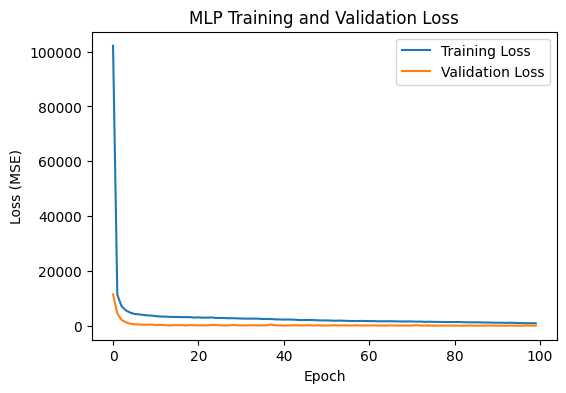

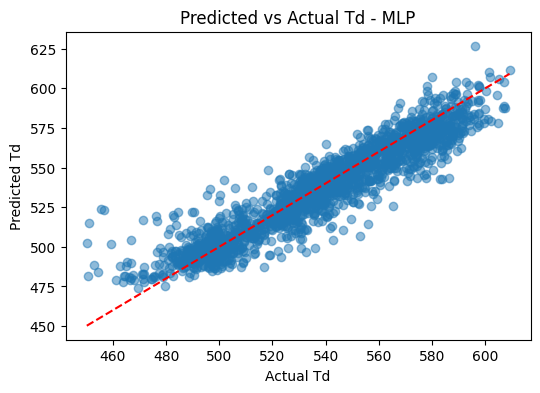


Training DNN...
Epoch 1/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 139602.2031 - mae: 309.7531 - val_loss: 4361.1396 - val_mae: 50.8830
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7691.7847 - mae: 69.6132 - val_loss: 1550.8213 - val_mae: 30.1299
Epoch 3/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5377.4126 - mae: 58.2856 - val_loss: 1087.4379 - val_mae: 25.1024
Epoch 4/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4347.7817 - mae: 52.6720 - val_loss: 1024.8170 - val_mae: 25.8962
Epoch 5/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4335.3760 - mae: 52.3724 - val_loss: 580.1566 - val_mae: 18.7833
Epoch 6/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4134.7817 - mae: 51.3790 - val_loss: 1011.1249 - val_mae: 27.3298
Epoch 7/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4014.2314 - mae: 50.6463 - val_loss: 409.3609 - val_mae: 14.9395
Epoch 8/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3993.7949 - mae: 50.1302 - val_l

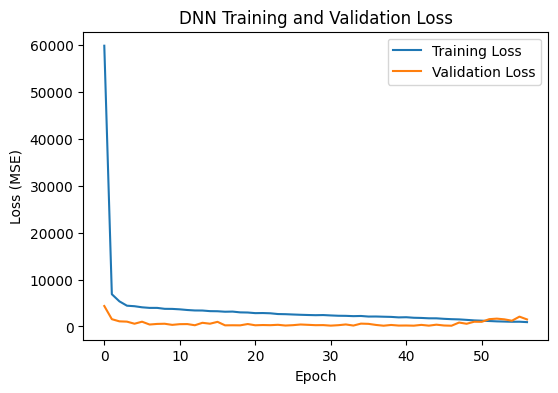

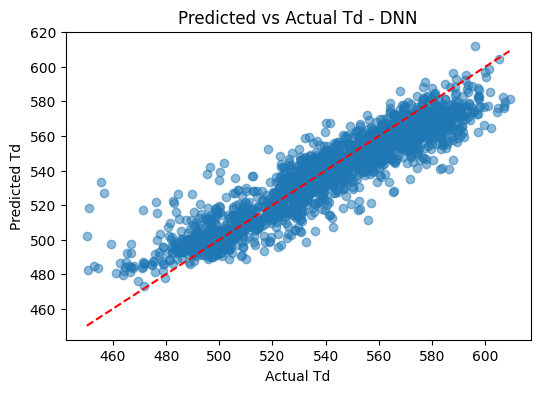


Training RNN...
Epoch 1/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 203808.9688 - mae: 416.2224 - val_loss: 11563.8506 - val_mae: 84.0285
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 13426.7275 - mae: 91.7549 - val_loss: 4176.4668 - val_mae: 49.3077
Epoch 3/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7402.6812 - mae: 67.7916 - val_loss: 1976.8639 - val_mae: 33.1134
Epoch 4/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6173.1929 - mae: 62.5152 - val_loss: 1393.4479 - val_mae: 28.4975
Epoch 5/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5031.2808 - mae: 56.4691 - val_loss: 1131.3322 - val_mae: 26.0338
Epoch 6/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4808.3677 - mae: 55.3131 - val_loss: 768.8988 - val_mae: 21.0238
Epoch 7/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4437.4854 - mae: 53.0273 - val_loss: 634.3779 - val_mae: 19.0421
Epoch 8/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4276.8291 - mae: 52.2225 - val

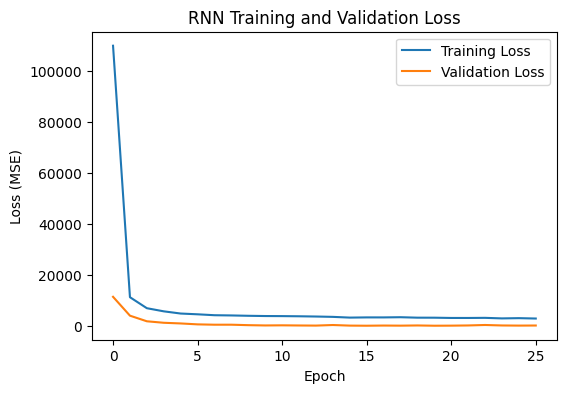

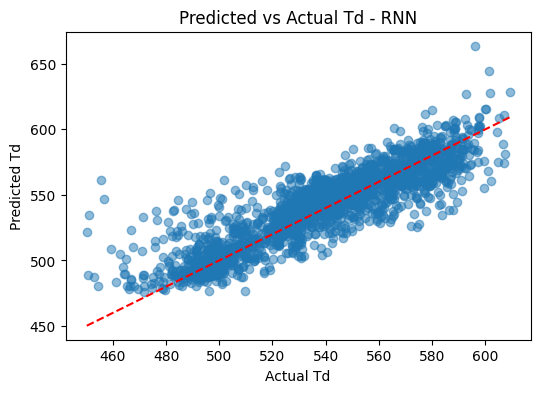


Neural Network Model Comparison Table:


,Model,RMSE,R2,Best Model
MLP,MLP,11.175414,0.875965,True
DNN,DNN,12.395384,0.847406,False
RNN,RNN,15.466518,0.762424,False



Best Neural Network Model: MLP

Enter a SMILES string (e.g., [*]OCCC(=O)[*]) or a pair (e.g., ['[*]OCCC(=O)[*]', '[*]OC(O)CC(=O)[*]']) or 'quit' to exit:
[*]OCCC(=O)[*]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Error: Invalid input: unsupported format string passed to numpy.ndarray.__format__

Enter a SMILES string (e.g., [*]OCCC(=O)[*]) or a pair (e.g., ['[*]OCCC(=O)[*]', '[*]OC(O)CC(=O)[*]']) or 'quit' to exit:
 ['[*]OCCC(=O)[*]


[15:41:37] SMILES Parse Error: syntax error while parsing: ['[*]OCCC(=O)[*]
[15:41:37] SMILES Parse Error: check for mistakes around position 2:
[15:41:37] ['[*]OCCC(=O)[*]
[15:41:37] ~^
[15:41:37] SMILES Parse Error: Failed parsing SMILES '['[*]OCCC(=O)[*]' for input: '['[*]OCCC(=O)[*]'


Error: Invalid input: Invalid SMILES string: ['[*]OCCC(=O)[*]

Enter a SMILES string (e.g., [*]OCCC(=O)[*]) or a pair (e.g., ['[*]OCCC(=O)[*]', '[*]OC(O)CC(=O)[*]']) or 'quit' to exit:
quit 
Exiting prediction.


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import ast

# Load and Clean the Dataset (from original code)
def load_and_clean_data(file_path):
    print(f"Attempting to load dataset from: {file_path}")
    try:
        df = pd.read_csv(file_path)
        print(f"Initial dataset loaded. Rows: {len(df)}, Columns: {list(df.columns)}")
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return pd.DataFrame()

    if df.empty:
        print("Error: Loaded dataset is empty.")
        return df

    required_cols = ['smiles', 'Td']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Warning: Missing required columns: {missing_cols}")
        if 'smiles' not in df.columns:
            df['smiles'] = '[*]OCCC(=O)[*]'
        if 'Td' not in df.columns:
            print("Error: 'Td' column is required.")
            return pd.DataFrame()

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

    initial_rows = len(df)
    df = df.drop_duplicates()
    print(f"Removed {initial_rows - len(df)} duplicate rows. Remaining rows: {len(df)}")

    def is_valid_smiles(smiles_input):
        try:
            try:
                smiles_list = ast.literal_eval(smiles_input)
                if not isinstance(smiles_list, list) or len(smiles_list) == 0 or len(smiles_list) > 2:
                    return False
                for smi in smiles_list:
                    if not isinstance(smi, str):
                        return False
                    mol = Chem.MolFromSmiles(smi, sanitize=True)
                    if mol is None:
                        return False
                return True
            except (ValueError, SyntaxError):
                if not isinstance(smiles_input, str):
                    return False
                mol = Chem.MolFromSmiles(smiles_input, sanitize=True)
                return mol is not None
        except Exception:
            return False

    if 'smiles' in df.columns:
        df['valid_smiles'] = df['smiles'].apply(is_valid_smiles)
        valid_rows = df['valid_smiles'].sum()
        print(f"SMILES validation: {valid_rows} valid, {len(df) - valid_rows} invalid")
        if valid_rows == 0:
            print("Warning: No valid SMILES found.")
        else:
            df = df[df['valid_smiles']]
        df = df.drop(columns=['valid_smiles'], errors='ignore')

    print(f"Final cleaned dataset. Rows: {len(df)}, Columns: {list(df.columns)}")
    return df

# Convert SMILES to Numerical Features (from original code)
def smiles_to_descriptors(smiles_input):
    default_descriptors = [0.0] * 10
    try:
        descriptors = []
        try:
            smiles_list = ast.literal_eval(smiles_input)
            if not isinstance(smiles_list, list) or len(smiles_list) == 0 or len(smiles_list) > 2:
                return default_descriptors
        except (ValueError, SyntaxError):
            smiles_list = [smiles_input]

        for smi in smiles_list:
            if not isinstance(smi, str):
                return default_descriptors
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                return default_descriptors
            desc = [
                Descriptors.MolWt(mol),
                Descriptors.NumValenceElectrons(mol),
                Descriptors.TPSA(mol),
                Descriptors.NumRotatableBonds(mol),
                Descriptors.MolLogP(mol)
            ]
            descriptors.extend(desc)

        if len(smiles_list) == 1:
            descriptors.extend([0.0] * 5)

        return descriptors
    except Exception:
        return default_descriptors

def prepare_features_and_target(df):
    if df.empty:
        print("Error: Input dataset is empty.")
        return pd.DataFrame(), pd.Series(), []

    if 'Td' not in df.columns:
        print("Error: 'Td' column missing from dataset.")
        return pd.DataFrame(), pd.Series(), []

    descriptor_cols = [
        'mol_wt_1', 'valence_electrons_1', 'tpsa_1', 'rot_bonds_1', 'logp_1',
        'mol_wt_2', 'valence_electrons_2', 'tpsa_2', 'rot_bonds_2', 'logp_2'
    ]

    if 'smiles' in df.columns:
        descriptors = df['smiles'].apply(smiles_to_descriptors)
        descriptor_df = pd.DataFrame(descriptors.tolist(), index=df.index, columns=descriptor_cols)
        df = pd.concat([df, descriptor_df], axis=1)
        print(f"Extracted descriptors for {len(df)} rows.")
    else:
        df[descriptor_cols] = 0.0

    feature_cols = descriptor_cols + [col for col in df.columns if col in ['comp', 'Tg', 'Tm', 'YM', 'TS_y', 'TS_b', 'eps_b', 'perm_O2', 'perm_CO2', 'perm_He', 'perm_N2', 'perm_CH4', 'perm_H2']]
    X = df[feature_cols]
    y = df['Td']

    print(f"Feature matrix shape: {X.shape}, Target shape: {y.shape}")
    return X, y, feature_cols

# Define Neural Network Models
def build_mlp(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_dnn(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def build_rnn(input_dim):
    model = Sequential([
        SimpleRNN(128, activation='relu', input_shape=(1, input_dim), return_sequences=True),
        Dropout(0.3),
        SimpleRNN(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train and Evaluate Neural Network Models
def train_and_evaluate_nn_models(X, y, feature_cols):
    if X.empty or y.empty:
        print("Error: Empty feature or target data.")
        return {}, {}, None, None

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training set: {X_train.shape[0]} rows, Test set: {X_test.shape[0]} rows")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape for RNN (samples, timesteps, features)
    X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    models = {
        'MLP': build_mlp(X_train_scaled.shape[1]),
        'DNN': build_dnn(X_train_scaled.shape[1]),
        'RNN': build_rnn(X_train_scaled.shape[1])
    }

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    results = {}
    predictions = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        if name == 'RNN':
            history = model.fit(
                X_train_rnn, y_train,
                validation_data=(X_test_rnn, y_test),
                epochs=100,
                batch_size=32,
                callbacks=[early_stopping],
                verbose=1
            )
            y_pred = model.predict(X_test_rnn).flatten()
        else:
            history = model.fit(
                X_train_scaled, y_train,
                validation_data=(X_test_scaled, y_test),
                epochs=100,
                batch_size=32,
                callbacks=[early_stopping],
                verbose=1
            )
            y_pred = model.predict(X_test_scaled).flatten()

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results[name] = {'RMSE': rmse, 'R2': r2}
        predictions[name] = y_pred

        # Plot training history
        plt.figure(figsize=(6, 4))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{name} Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.savefig(f'{name.lower()}_loss_curve.png')
        plt.show()

        # Scatter plot: Predicted vs Actual
        plt.figure(figsize=(6, 4))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Actual Td')
        plt.ylabel('Predicted Td')
        plt.title(f'Predicted vs Actual Td - {name}')
        plt.savefig(f'scatter_{name.lower()}.png')
        plt.show()

    # Comparison table
    comparison_df = pd.DataFrame(results).T
    comparison_df['Model'] = comparison_df.index
    best_model_name = comparison_df['R2'].idxmax()
    comparison_df['Best Model'] = comparison_df.index == best_model_name
    print("\nNeural Network Model Comparison Table:")
    display(comparison_df[['Model', 'RMSE', 'R2', 'Best Model']])

    best_model = models[best_model_name]
    return results, models, scaler, best_model_name, best_model

# CLI for Predicting Td
def predict_td_cli(scaler, best_model, feature_cols, model_name):
    while True:
        print("\nEnter a SMILES string (e.g., [*]OCCC(=O)[*]) or a pair (e.g., ['[*]OCCC(=O)[*]', '[*]OC(O)CC(=O)[*]']) or 'quit' to exit:")
        smiles_input = input().strip()

        if smiles_input.lower() == 'quit':
            print("Exiting prediction.")
            break

        try:
            try:
                smiles_list = ast.literal_eval(smiles_input)
                if not isinstance(smiles_list, list) or len(smiles_list) == 0 or len(smiles_list) > 2:
                    raise ValueError("SMILES list must contain 1 or 2 strings")
                smiles_input = str(smiles_list)
            except (ValueError, SyntaxError):
                mol = Chem.MolFromSmiles(smiles_input)
                if mol is None:
                    raise ValueError(f"Invalid SMILES string: {smiles_input}")
                smiles_input = f"['{smiles_input}']"

            input_df = pd.DataFrame({'smiles': [smiles_input]})
            descriptors = smiles_to_descriptors(smiles_input)
            descriptor_df = pd.DataFrame([descriptors], columns=[
                'mol_wt_1', 'valence_electrons_1', 'tpsa_1', 'rot_bonds_1', 'logp_1',
                'mol_wt_2', 'valence_electrons_2', 'tpsa_2', 'rot_bonds_2', 'logp_2'
            ])

            for col in feature_cols:
                if col not in descriptor_df.columns:
                    descriptor_df[col] = 0.0

            X_input = descriptor_df[feature_cols]
            X_input_scaled = scaler.transform(X_input)

            if model_name == 'RNN':
                X_input_rnn = X_input_scaled.reshape((X_input_scaled.shape[0], 1, X_input_scaled.shape[1]))
                prediction = best_model.predict(X_input_rnn)[0][0]
            else:
                prediction = best_model.predict(X_input_scaled)[0]

            print(f"Predicted Td: {prediction:.2f}")
        except Exception as e:
            print(f"Error: Invalid input: {str(e)}")

# Main Execution
if __name__ == "__main__":
    file_path = '/content/10000.csv'

    df_cleaned = load_and_clean_data(file_path)

    if df_cleaned.empty:
        print("Error: Cleaned dataset is empty.")
    else:
        df_cleaned.to_csv('cleaned_10000.csv', index=False)
        print("\nCleaned dataset saved as 'cleaned_10000.csv'")

        X, y, feature_cols = prepare_features_and_target(df_cleaned)

        if X.empty or y.empty:
            print("Error: No features or target data available.")
        else:
            results, nn_models, scaler, best_model_name, best_model = train_and_evaluate_nn_models(X, y, feature_cols)

            if results:
                for name, model in nn_models.items():
                    model.save(f"{name.lower()}_model.h5")
                joblib.dump(scaler, 'scaler.pkl')
                print(f"\nBest Neural Network Model: {best_model_name}")
                predict_td_cli(scaler, best_model, feature_cols, best_model_name)
            else:
                print("No models trained due to errors.")

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu117.html

Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.9 MB/s eta 0:00:00
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=547368 sha256=78fdd414087a2b6f6793fd562c4fd9d9f86e367c7a9346b02d4a72bce5622a1b
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=1127937 sha256=da74aa14a3a116b

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import ast

# Load and Clean the Dataset
def load_and_clean_data(file_path):
    print(f"Attempting to load dataset from: {file_path}")
    try:
        df = pd.read_csv(file_path)
        print(f"Initial dataset loaded. Rows: {len(df)}, Columns: {list(df.columns)}")
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return pd.DataFrame()

    if df.empty:
        print("Error: Loaded dataset is empty.")
        return df

    required_cols = ['smiles', 'Td']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Warning: Missing required columns: {missing_cols}")
        if 'smiles' not in df.columns:
            df['smiles'] = '[*]OCCC(=O)[*]'
        if 'Td' not in df.columns:
            print("Error: 'Td' column is required.")
            return pd.DataFrame()

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

    initial_rows = len(df)
    df = df.drop_duplicates()
    print(f"Removed {initial_rows - len(df)} duplicate rows. Remaining rows: {len(df)}")

    def is_valid_smiles(smiles_input):
        try:
            try:
                smiles_list = ast.literal_eval(smiles_input)
                if not isinstance(smiles_list, list) or len(smiles_list) == 0 or len(smiles_list) > 2:
                    return False
                for smi in smiles_list:
                    if not isinstance(smi, str):
                        return False
                    mol = Chem.MolFromSmiles(smi, sanitize=True)
                    if mol is None:
                        return False
                return True
            except (ValueError, SyntaxError):
                if not isinstance(smiles_input, str):
                    return False
                mol = Chem.MolFromSmiles(smiles_input, sanitize=True)
                return mol is not None
        except Exception:
            return False

    if 'smiles' in df.columns:
        df['valid_smiles'] = df['smiles'].apply(is_valid_smiles)
        valid_rows = df['valid_smiles'].sum()
        print(f"SMILES validation: {valid_rows} valid, {len(df) - valid_rows} invalid")
        if valid_rows == 0:
            print("Warning: No valid SMILES found.")
        else:
            df = df[df['valid_smiles']]
        df = df.drop(columns=['valid_smiles'], errors='ignore')

    print(f"Final cleaned dataset. Rows: {len(df)}, Columns: {list(df.columns)}")
    return df

# Convert SMILES to Numerical Features
def smiles_to_descriptors(smiles_input):
    default_descriptors = [0.0] * 10
    try:
        descriptors = []
        try:
            smiles_list = ast.literal_eval(smiles_input)
            if not isinstance(smiles_list, list) or len(smiles_list) == 0 or len(smiles_list) > 2:
                return default_descriptors
        except (ValueError, SyntaxError):
            smiles_list = [smiles_input]

        for smi in smiles_list:
            if not isinstance(smi, str):
                return default_descriptors
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                return default_descriptors
            desc = [
                Descriptors.MolWt(mol),
                Descriptors.NumValenceElectrons(mol),
                Descriptors.TPSA(mol),
                Descriptors.NumRotatableBonds(mol),
                Descriptors.MolLogP(mol)
            ]
            descriptors.extend(desc)

        if len(smiles_list) == 1:
            descriptors.extend([0.0] * 5)

        return descriptors
    except Exception:
        return default_descriptors

def prepare_features_and_target(df):
    if df.empty:
        print("Error: Input dataset is empty.")
        return pd.DataFrame(), pd.Series(), []

    if 'Td' not in df.columns:
        print("Error: 'Td' column missing from dataset.")
        return pd.DataFrame(), pd.Series(), []

    descriptor_cols = [
        'mol_wt_1', 'valence_electrons_1', 'tpsa_1', 'rot_bonds_1', 'logp_1',
        'mol_wt_2', 'valence_electrons_2', 'tpsa_2', 'rot_bonds_2', 'logp_2'
    ]

    if 'smiles' in df.columns:
        descriptors = df['smiles'].apply(smiles_to_descriptors)
        descriptor_df = pd.DataFrame(descriptors.tolist(), index=df.index, columns=descriptor_cols)
        df = pd.concat([df, descriptor_df], axis=1)
        print(f"Extracted descriptors for {len(df)} rows.")
    else:
        df[descriptor_cols] = 0.0

    feature_cols = descriptor_cols + [col for col in df.columns if col in ['comp', 'Tg', 'Tm', 'YM', 'TS_y', 'TS_b', 'eps_b', 'perm_O2', 'perm_CO2', 'perm_He', 'perm_N2', 'perm_CH4', 'perm_H2']]
    X = df[feature_cols]
    y = df['Td']

    print(f"Feature matrix shape: {X.shape}, Target shape: {y.shape}")
    return X, y, feature_cols

# Define Alternative Deep Learning Models
def build_cnn(input_dim):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(input_dim, 1), padding='same'),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_lstm(input_dim):
    model = Sequential([
        LSTM(128, activation='relu', input_shape=(1, input_dim), return_sequences=True),
        Dropout(0.3),
        LSTM(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_gru(input_dim):
    model = Sequential([
        GRU(128, activation='relu', input_shape=(1, input_dim), return_sequences=True),
        Dropout(0.3),
        GRU(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train and Evaluate Neural Network Models
def train_and_evaluate_nn_models(X, y, feature_cols):
    if X.empty or y.empty:
        print("Error: Empty feature or target data.")
        return {}, {}, None, None, None

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training set: {X_train.shape[0]} rows, Test set: {X_test.shape[0]} rows")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape for CNN (samples, input_dim, 1)
    X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    # Reshape for LSTM and GRU (samples, timesteps=1, features)
    X_train_seq = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_seq = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    models = {
        'CNN': build_cnn(X_train_scaled.shape[1]),
        'LSTM': build_lstm(X_train_scaled.shape[1]),
        'GRU': build_gru(X_train_scaled.shape[1])
    }

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    results = {}
    predictions = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        if name == 'CNN':
            history = model.fit(
                X_train_cnn, y_train,
                validation_data=(X_test_cnn, y_test),
                epochs=100,
                batch_size=32,
                callbacks=[early_stopping],
                verbose=1
            )
            y_pred = model.predict(X_test_cnn).flatten()
        else:  # LSTM or GRU
            history = model.fit(
                X_train_seq, y_train,
                validation_data=(X_test_seq, y_test),
                epochs=100,
                batch_size=32,
                callbacks=[early_stopping],
                verbose=1
            )
            y_pred = model.predict(X_test_seq).flatten()

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results[name] = {'RMSE': rmse, 'R2': r2}
        predictions[name] = y_pred

        # Plot training history
        plt.figure(figsize=(6, 4))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{name} Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.savefig(f'{name.lower()}_loss_curve.png')
        plt.close()

        # Scatter plot: Predicted vs Actual
        plt.figure(figsize=(6, 4))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Actual Td')
        plt.ylabel('Predicted Td')
        plt.title(f'Predicted vs Actual Td - {name}')
        plt.savefig(f'scatter_{name.lower()}.png')
        plt.close()

    # Comparison table
    comparison_df = pd.DataFrame(results).T
    comparison_df['Model'] = comparison_df.index
    best_model_name = comparison_df['R2'].idxmax()
    comparison_df['Best Model'] = comparison_df.index == best_model_name
    print("\nNeural Network Model Comparison Table:")
    display(comparison_df[['Model', 'RMSE', 'R2', 'Best Model']])

    best_model = models[best_model_name]
    return results, models, scaler, best_model_name, best_model

# CLI for Predicting Td
def predict_td_cli(scaler, best_model, feature_cols, model_name):
    while True:
        print("\nEnter a SMILES string (e.g., [*]OCCC(=O)[*]) or a pair (e.g., ['[*]OCCC(=O)[*]', '[*]OC(O)CC(=O)[*]']) or 'quit' to exit:")
        smiles_input = input().strip()

        if smiles_input.lower() == 'quit':
            print("Exiting prediction.")
            break

        try:
            try:
                smiles_list = ast.literal_eval(smiles_input)
                if not isinstance(smiles_list, list) or len(smiles_list) == 0 or len(smiles_list) > 2:
                    raise ValueError("SMILES list must contain 1 or 2 strings")
                smiles_input = str(smiles_list)
            except (ValueError, SyntaxError):
                mol = Chem.MolFromSmiles(smiles_input)
                if mol is None:
                    raise ValueError(f"Invalid SMILES string: {smiles_input}")
                smiles_input = f"['{smiles_input}']"

            input_df = pd.DataFrame({'smiles': [smiles_input]})
            descriptors = smiles_to_descriptors(smiles_input)
            descriptor_df = pd.DataFrame([descriptors], columns=[
                'mol_wt_1', 'valence_electrons_1', 'tpsa_1', 'rot_bonds_1', 'logp_1',
                'mol_wt_2', 'valence_electrons_2', 'tpsa_2', 'rot_bonds_2', 'logp_2'
            ])

            for col in feature_cols:
                if col not in descriptor_df.columns:
                    descriptor_df[col] = 0.0

            X_input = descriptor_df[feature_cols]
            X_input_scaled = scaler.transform(X_input)

            if model_name == 'CNN':
                X_input_cnn = X_input_scaled.reshape((X_input_scaled.shape[0], X_input_scaled.shape[1], 1))
                prediction = best_model.predict(X_input_cnn)[0][0]
            else:  # LSTM or GRU
                X_input_seq = X_input_scaled.reshape((X_input_scaled.shape[0], 1, X_input_scaled.shape[1]))
                prediction = best_model.predict(X_input_seq)[0][0]

            print(f"Predicted Td: {prediction:.2f}")
        except Exception as e:
            print(f"Error: Invalid input: {str(e)}")

# Main Execution
if __name__ == "__main__":
    file_path = '/content/10000.csv'

    df_cleaned = load_and_clean_data(file_path)

    if df_cleaned.empty:
        print("Error: Cleaned dataset is empty.")
    else:
        df_cleaned.to_csv('cleaned_10000.csv', index=False)
        print("\nCleaned dataset saved as 'cleaned_10000.csv'")

        X, y, feature_cols = prepare_features_and_target(df_cleaned)

        if X.empty or y.empty:
            print("Error: No features or target data available.")
        else:
            results, nn_models, scaler, best_model_name, best_model = train_and_evaluate_nn_models(X, y, feature_cols)

            if results:
                for name, model in nn_models.items():
                    model.save(f"{name.lower()}_model.h5")
                joblib.dump(scaler, 'scaler.pkl')
                print(f"\nBest Neural Network Model: {best_model_name}")
                predict_td_cli(scaler, best_model, feature_cols, best_model_name)
            else:
                print("No models trained due to errors.")

Attempting to load dataset from: /content/10000.csv
Initial dataset loaded. Rows: 10049, Columns: ['comp', 'Tg', 'Tm', 'Td', 'YM', 'TS_y', 'TS_b', 'eps_b', 'perm_O2', 'perm_CO2', 'perm_He', 'perm_N2', 'perm_CH4', 'perm_H2', 'smiles', 'num_side', 'num_back', 'end_group']
Removed 0 duplicate rows. Remaining rows: 10049
SMILES validation: 10049 valid, 0 invalid
Final cleaned dataset. Rows: 10049, Columns: ['comp', 'Tg', 'Tm', 'Td', 'YM', 'TS_y', 'TS_b', 'eps_b', 'perm_O2', 'perm_CO2', 'perm_He', 'perm_N2', 'perm_CH4', 'perm_H2', 'smiles', 'num_side', 'num_back', 'end_group']

Cleaned dataset saved as 'cleaned_10000.csv'
Extracted descriptors for 10049 rows.
Feature matrix shape: (10049, 23), Target shape: (10049,)
Training set: 8039 rows, Test set: 2010 rows


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training CNN...
Epoch 1/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 128062.9453 - mae: 291.4177 - val_loss: 4820.9263 - val_mae: 55.3518
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9164.4434 - mae: 77.1362 - val_loss: 1958.1636 - val_mae: 34.3677
Epoch 3/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6700.8584 - mae: 65.4495 - val_loss: 1130.6237 - val_mae: 26.1429
Epoch 4/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5917.7329 - mae: 61.4300 - val_loss: 1386.0431 - val_mae: 28.8892
Epoch 5/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5653.5308 - mae: 59.6030 - val_loss: 715.9926 - val_mae: 20.4913
Epoch 6/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5423.5786 - mae: 58.9042 - val_loss: 554.1623 - val_mae: 18.8198
Epoch 7/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5739.8633 - mae: 60.3648 - val_loss: 669.7156 - val_mae: 20.7629
Epoch 8/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5580.9150 - mae: 59.6002 - val_lo

<ipython-input-4-95a668094ba5>:255: UserWarning: Glyph 4 () missing from font(s) DejaVu Sans.
  plt.savefig(f'{name.lower()}_loss_curve.png')



Training LSTM...
Epoch 1/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 226749.2812 - mae: 450.0153 - val_loss: 27767.3652 - val_mae: 130.7285
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 26552.7930 - mae: 128.4214 - val_loss: 9178.4551 - val_mae: 73.4562
Epoch 3/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 11651.0762 - mae: 85.4101 - val_loss: 3354.0452 - val_mae: 42.9393
Epoch 4/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 6460.6309 - mae: 63.8937 - val_loss: 1704.4706 - val_mae: 30.0024
Epoch 5/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5287.1006 - mae: 58.2330 - val_loss: 1125.3409 - val_mae: 24.8147
Epoch 6/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4788.1567 - mae: 54.9525 - val_loss: 848.7556 - val_mae: 21.9098
Epoch 7/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4395.6240 - mae: 52.5173 - val_loss: 510.0269 - val_mae: 16.9970
Epoch 8/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4081.7395 - mae: 50.4774 

<ipython-input-4-95a668094ba5>:255: UserWarning: Glyph 4 () missing from font(s) DejaVu Sans.
  plt.savefig(f'{name.lower()}_loss_curve.png')



Training GRU...
Epoch 1/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 214052.8750 - mae: 430.6687 - val_loss: 12426.9229 - val_mae: 86.7132
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 13335.2314 - mae: 91.4402 - val_loss: 3061.4595 - val_mae: 42.2316
Epoch 3/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 6766.0562 - mae: 64.7943 - val_loss: 1280.7502 - val_mae: 26.7298
Epoch 4/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5171.1997 - mae: 57.3384 - val_loss: 891.6605 - val_mae: 22.0921
Epoch 5/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4853.0850 - mae: 55.2428 - val_loss: 641.8962 - val_mae: 19.8776
Epoch 6/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4516.4019 - mae: 53.7931 - val_loss: 620.1549 - val_mae: 19.4497
Epoch 7/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4307.1021 - mae: 52.6023 - val_loss: 491.5246 - val_mae: 17.3334
Epoch 8/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4045.3958 - mae: 50.6815 - val_

<ipython-input-4-95a668094ba5>:255: UserWarning: Glyph 4 () missing from font(s) DejaVu Sans.
  plt.savefig(f'{name.lower()}_loss_curve.png')



Neural Network Model Comparison Table:


,Model,RMSE,R2,Best Model
CNN,CNN,13.446480,0.820430,False
LSTM,LSTM,13.160924,0.827975,False
GRU,GRU,12.869739,0.835503,True



Best Neural Network Model: GRU

Enter a SMILES string (e.g., [*]OCCC(=O)[*]) or a pair (e.g., ['[*]OCCC(=O)[*]', '[*]OC(O)CC(=O)[*]']) or 'quit' to exit:
[*]OCCC(=O)[*]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Td: 639.65

Enter a SMILES string (e.g., [*]OCCC(=O)[*]) or a pair (e.g., ['[*]OCCC(=O)[*]', '[*]OC(O)CC(=O)[*]']) or 'quit' to exit:
quit
Exiting prediction.


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import ast

# Load and Clean the Dataset
def load_and_clean_data(file_path):
    print(f"Attempting to load dataset from: {file_path}")
    try:
        df = pd.read_csv(file_path)
        print(f"Initial dataset loaded. Rows: {len(df)}, Columns: {list(df.columns)}")
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return pd.DataFrame()

    if df.empty:
        print("Error: Loaded dataset is empty.")
        return df

    required_cols = ['smiles', 'Td']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Warning: Missing required columns: {missing_cols}")
        if 'smiles' not in df.columns:
            df['smiles'] = '[*]OCCC(=O)[*]'
        if 'Td' not in df.columns:
            print("Error: 'Td' column is required.")
            return pd.DataFrame()

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

    initial_rows = len(df)
    df = df.drop_duplicates()
    print(f"Removed {initial_rows - len(df)} duplicate rows. Remaining rows: {len(df)}")

    def is_valid_smiles(smiles_input):
        try:
            try:
                smiles_list = ast.literal_eval(smiles_input)
                if not isinstance(smiles_list, list) or len(smiles_list) == 0 or len(smiles_list) > 2:
                    return False
                for smi in smiles_list:
                    if not isinstance(smi, str):
                        return False
                    mol = Chem.MolFromSmiles(smi, sanitize=True)
                    if mol is None:
                        return False
                return True
            except (ValueError, SyntaxError):
                if not isinstance(smiles_input, str):
                    return False
                mol = Chem.MolFromSmiles(smiles_input, sanitize=True)
                return mol is not None
        except Exception:
            return False

    if 'smiles' in df.columns:
        df['valid_smiles'] = df['smiles'].apply(is_valid_smiles)
        valid_rows = df['valid_smiles'].sum()
        print(f"SMILES validation: {valid_rows} valid, {len(df) - valid_rows} invalid")
        if valid_rows == 0:
            print("Warning: No valid SMILES found.")
        else:
            df = df[df['valid_smiles']]
        df = df.drop(columns=['valid_smiles'], errors='ignore')

    print(f"Final cleaned dataset. Rows: {len(df)}, Columns: {list(df.columns)}")
    return df

# Convert SMILES to Numerical Features
def smiles_to_descriptors(smiles_input):
    default_descriptors = [0.0] * 10
    try:
        descriptors = []
        try:
            smiles_list = ast.literal_eval(smiles_input)
            if not isinstance(smiles_list, list) or len(smiles_list) == 0 or len(smiles_list) > 2:
                return default_descriptors
        except (ValueError, SyntaxError):
            smiles_list = [smiles_input]

        for smi in smiles_list:
            if not isinstance(smi, str):
                return default_descriptors
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                return default_descriptors
            desc = [
                Descriptors.MolWt(mol),
                Descriptors.NumValenceElectrons(mol),
                Descriptors.TPSA(mol),
                Descriptors.NumRotatableBonds(mol),
                Descriptors.MolLogP(mol)
            ]
            descriptors.extend(desc)

        if len(smiles_list) == 1:
            descriptors.extend([0.0] * 5)

        return descriptors
    except Exception:
        return default_descriptors

def prepare_features_and_target(df):
    if df.empty:
        print("Error: Input dataset is empty.")
        return pd.DataFrame(), pd.Series(), []

    if 'Td' not in df.columns:
        print("Error: 'Td' column missing from dataset.")
        return pd.DataFrame(), pd.Series(), []

    descriptor_cols = [
        'mol_wt_1', 'valence_electrons_1', 'tpsa_1', 'rot_bonds_1', 'logp_1',
        'mol_wt_2', 'valence_electrons_2', 'tpsa_2', 'rot_bonds_2', 'logp_2'
    ]

    if 'smiles' in df.columns:
        descriptors = df['smiles'].apply(smiles_to_descriptors)
        descriptor_df = pd.DataFrame(descriptors.tolist(), index=df.index, columns=descriptor_cols)
        df = pd.concat([df, descriptor_df], axis=1)
        print(f"Extracted descriptors for {len(df)} rows.")
    else:
        df[descriptor_cols] = 0.0

    feature_cols = descriptor_cols + [col for col in df.columns if col in ['comp', 'Tg', 'Tm', 'YM', 'TS_y', 'TS_b', 'eps_b', 'perm_O2', 'perm_CO2', 'perm_He', 'perm_N2', 'perm_CH4', 'perm_H2']]
    X = df[feature_cols]
    y = df['Td']

    print(f"Feature matrix shape: {X.shape}, Target shape: {y.shape}")
    return X, y, feature_cols

# Define Hybrid Deep Learning Models
def build_cnn_lstm_hybrid(input_dim):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(input_dim, 1), padding='same'),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        # Reshape for LSTM: Flatten and add time dimension
        tf.keras.layers.Reshape((-1, 32)),  # Assuming output from Conv1D is (None, seq_len, 32)
        LSTM(64, activation='relu', return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_cnn_gru_hybrid(input_dim):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(input_dim, 1), padding='same'),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        # Reshape for GRU
        tf.keras.layers.Reshape((-1, 32)),  # Assuming output from Conv1D is (None, seq_len, 32)
        GRU(64, activation='relu', return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_cnn_dense_hybrid(input_dim):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(input_dim, 1), padding='same'),
        MaxPooling1D(pool_size=2),
        Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train and Evaluate Neural Network Models
def train_and_evaluate_nn_models(X, y, feature_cols):
    if X.empty or y.empty:
        print("Error: Empty feature or target data.")
        return {}, {}, None, None, None

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training set: {X_train.shape[0]} rows, Test set: {X_test.shape[0]} rows")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape for hybrid models (samples, input_dim, 1)
    X_train_hybrid = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_test_hybrid = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    models = {
        'CNN-LSTM': build_cnn_lstm_hybrid(X_train_scaled.shape[1]),
        'CNN-GRU': build_cnn_gru_hybrid(X_train_scaled.shape[1]),
        'CNN-Dense': build_cnn_dense_hybrid(X_train_scaled.shape[1])
    }

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    results = {}
    predictions = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        history = model.fit(
            X_train_hybrid, y_train,
            validation_data=(X_test_hybrid, y_test),
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=1
        )
        y_pred = model.predict(X_test_hybrid).flatten()

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results[name] = {'RMSE': rmse, 'R2': r2}
        predictions[name] = y_pred

        # Plot training history
        plt.figure(figsize=(6, 4))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{name} Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.savefig(f'{name.lower().replace("-", "_")}_loss_curve.png')
        plt.close()

        # Scatter plot: Predicted vs Actual
        plt.figure(figsize=(6, 4))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Actual Td')
        plt.ylabel('Predicted Td')
        plt.title(f'Predicted vs Actual Td - {name}')
        plt.savefig(f'scatter_{name.lower().replace("-", "_")}.png')
        plt.close()

    # Comparison table
    comparison_df = pd.DataFrame(results).T
    comparison_df['Model'] = comparison_df.index
    best_model_name = comparison_df['R2'].idxmax()
    comparison_df['Best Model'] = comparison_df.index == best_model_name
    print("\nHybrid Neural Network Model Comparison Table:")
    display(comparison_df[['Model', 'RMSE', 'R2', 'Best Model']])

    best_model = models[best_model_name]
    return results, models, scaler, best_model_name, best_model

# CLI for Predicting Td
def predict_td_cli(scaler, best_model, feature_cols, model_name):
    while True:
        print("\nEnter a SMILES string (e.g., [*]OCCC(=O)[*]) or a pair (e.g., ['[*]OCCC(=O)[*]', '[*]OC(O)CC(=O)[*]']) or 'quit' to exit:")
        smiles_input = input().strip()

        if smiles_input.lower() == 'quit':
            print("Exiting prediction.")
            break

        try:
            try:
                smiles_list = ast.literal_eval(smiles_input)
                if not isinstance(smiles_list, list) or len(smiles_list) == 0 or len(smiles_list) > 2:
                    raise ValueError("SMILES list must contain 1 or 2 strings")
                smiles_input = str(smiles_list)
            except (ValueError, SyntaxError):
                mol = Chem.MolFromSmiles(smiles_input)
                if mol is None:
                    raise ValueError(f"Invalid SMILES string: {smiles_input}")
                smiles_input = f"['{smiles_input}']"

            input_df = pd.DataFrame({'smiles': [smiles_input]})
            descriptors = smiles_to_descriptors(smiles_input)
            descriptor_df = pd.DataFrame([descriptors], columns=[
                'mol_wt_1', 'valence_electrons_1', 'tpsa_1', 'rot_bonds_1', 'logp_1',
                'mol_wt_2', 'valence_electrons_2', 'tpsa_2', 'rot_bonds_2', 'logp_2'
            ])

            for col in feature_cols:
                if col not in descriptor_df.columns:
                    descriptor_df[col] = 0.0

            X_input = descriptor_df[feature_cols]
            X_input_scaled = scaler.transform(X_input)

            # Reshape for hybrid models
            X_input_hybrid = X_input_scaled.reshape((X_input_scaled.shape[0], X_input_scaled.shape[1], 1))
            prediction = best_model.predict(X_input_hybrid)[0][0]

            print(f"Predicted Td: {prediction:.2f}")
        except Exception as e:
            print(f"Error: Invalid input: {str(e)}")

# Main Execution
if __name__ == "__main__":
    file_path = '/content/10000.csv'

    df_cleaned = load_and_clean_data(file_path)

    if df_cleaned.empty:
        print("Error: Cleaned dataset is empty.")
    else:
        df_cleaned.to_csv('cleaned_10000.csv', index=False)
        print("\nCleaned dataset saved as 'cleaned_10000.csv'")

        X, y, feature_cols = prepare_features_and_target(df_cleaned)

        if X.empty or y.empty:
            print("Error: No features or target data available.")
        else:
            results, nn_models, scaler, best_model_name, best_model = train_and_evaluate_nn_models(X, y, feature_cols)

            if results:
                for name, model in nn_models.items():
                    model.save(f"{name.lower().replace('-', '_')}_model.h5")
                joblib.dump(scaler, 'scaler.pkl')
                print(f"\nBest Hybrid Neural Network Model: {best_model_name}")
                predict_td_cli(scaler, best_model, feature_cols, best_model_name)
            else:
                print("No models trained due to errors.")

Attempting to load dataset from: /content/10000.csv
Initial dataset loaded. Rows: 10049, Columns: ['comp', 'Tg', 'Tm', 'Td', 'YM', 'TS_y', 'TS_b', 'eps_b', 'perm_O2', 'perm_CO2', 'perm_He', 'perm_N2', 'perm_CH4', 'perm_H2', 'smiles', 'num_side', 'num_back', 'end_group']
Removed 0 duplicate rows. Remaining rows: 10049
SMILES validation: 10049 valid, 0 invalid
Final cleaned dataset. Rows: 10049, Columns: ['comp', 'Tg', 'Tm', 'Td', 'YM', 'TS_y', 'TS_b', 'eps_b', 'perm_O2', 'perm_CO2', 'perm_He', 'perm_N2', 'perm_CH4', 'perm_H2', 'smiles', 'num_side', 'num_back', 'end_group']

Cleaned dataset saved as 'cleaned_10000.csv'
Extracted descriptors for 10049 rows.
Feature matrix shape: (10049, 23), Target shape: (10049,)
Training set: 8039 rows, Test set: 2010 rows


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training CNN-LSTM...
Epoch 1/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 163001.0000 - mae: 348.8843 - val_loss: 2004.2999 - val_mae: 36.3544
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 13612.6152 - mae: 93.8619 - val_loss: 850.1173 - val_mae: 23.9811
Epoch 3/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 11642.7227 - mae: 86.4044 - val_loss: 691.7650 - val_mae: 20.6539
Epoch 4/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 11075.8184 - mae: 84.6240 - val_loss: 2686.7217 - val_mae: 47.3085
Epoch 5/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 11541.9922 - mae: 86.4877 - val_loss: 391.6366 - val_mae: 15.6351
Epoch 6/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 10957.4648 - mae: 83.6396 - val_loss: 765.4462 - val_mae: 23.0317
Epoch 7/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 10670.4473 - mae: 82.9672 - val_loss: 2005.8241 - val_mae: 40.7830
Epoch 8/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 11208.2373 - mae: 84

,Model,RMSE,R2,Best Model
CNN-LSTM,CNN-LSTM,16.021232,0.745077,False
CNN-GRU,CNN-GRU,18.059672,0.676080,False
CNN-Dense,CNN-Dense,15.512752,0.761001,True



Best Hybrid Neural Network Model: CNN-Dense

Enter a SMILES string (e.g., [*]OCCC(=O)[*]) or a pair (e.g., ['[*]OCCC(=O)[*]', '[*]OC(O)CC(=O)[*]']) or 'quit' to exit:
 [*]OCCC(=O)[*]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Td: 727.41

Enter a SMILES string (e.g., [*]OCCC(=O)[*]) or a pair (e.g., ['[*]OCCC(=O)[*]', '[*]OC(O)CC(=O)[*]']) or 'quit' to exit:
quit
Exiting prediction.
